# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

Шаги для выбора локации:
* В избранном регионе ищут месторождения, для каждого определяют значения признаков;
* Строят модель и оценивают объём запасов;
* Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
* Прибыль равна суммарной прибыли отобранных месторождений.

**Инструкция по выполнению проекта**
1. Загрузите и подготовьте данные. Поясните порядок действий.
1. Обучите и проверьте модель для каждого региона:
  1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
  1. Обучите модель и сделайте предсказания на валидационной выборке.
  1. Сохраните предсказания и правильные ответы на валидационной выборке.
  1. Напечатайте на экране средний запас сырья и RMSE модели.
  1. Проанализируйте результаты.
1. Подготовьтесь к расчёту прибыли:
  1. Сохраните в коде все ключевые значения для расчётов.
  1. Посчитайте минимальный средний объём сырья в месторождениях региона, достаточный для его разработки. Напишите выводы.
  1. Напишите функцию для расчёта прибыли по набору отобранных месторождений и предсказаний модели.
1. Посчитайте риски и прибыль для каждого региона:
  1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
  1. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков.
  1.  Напишите выводы: предложите регион для разработки месторождений и обоснуйте выбор.
  
**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах: geo_data_0.csv, geo_data_1.csv и geo_data_2.csv.

* id — уникальный идентификатор месторождения;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в месторождении (тыс. баррелей).

**Условия задачи:**

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона проводится исследование 500 точек.
* Бюджет на разработку месторождений — 10 млрд рублей, стоимость бурения одной скважины — 50 млн рублей.
* Один баррель сырья приносит 4500 рублей прибыли.
* Не рассматривать регионы, в которых риск убытков выше 2.5%. Из оставшихся выбирается регион с наибольшей средней прибылью.

# 1. Загрузка и подготовка данных

Импортируем все необходимое и объявим все необходимые константы из условия

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, make_scorer
from collections import defaultdict

SEED = 21

WELL_POINTS = 500
BOOTSTRAP_SAMPLES = 1000
TOTAL_BUDGET = 10e9
ONE_WELL_COST = 50e6
BARREL_PROFIT = 4500
RISK_TRESHOLD = 0.025
CONF_INTERVAL = 0.95

PATH_TO_DATA = '/datasets/'

Загрузим данные в список из `DataFrame`

In [2]:
files = ['geo_data_0.csv', 'geo_data_1.csv', 'geo_data_2.csv']
dfs = []

for file in files:
    with open(os.path.join(PATH_TO_DATA, file)) as f:
        dfs.append(pd.read_csv(f, index_col='id'))

Разделим данные на признаки и целевое значение

In [3]:
XX = []
yy = []

for df in dfs:
    XX.append(df.drop(columns=['product']))
    yy.append(df['product'])

# 2. Обучение и проверка модели

Разобьем каждый датасет на обучающую и валидационную выборку

In [4]:
all_splits = train_test_split(*XX, *yy, test_size=0.25, random_state=SEED)

XX_train = all_splits[0: len(XX)*2: 2]
XX_valid = all_splits[1: len(XX)*2: 2]
yy_train = all_splits[len(XX)*2: len(all_splits): 2]
yy_valid = all_splits[len(XX)*2+1: len(all_splits): 2]

<font color=green>Очень хороший код получился:)</font>

Обучим модель на каждой выборке, и проверим RMSE для каждого месторождения


In [6]:
def rmse(y_true, y_pred):
    return (mean_squared_error(y_true, y_pred))**(1/2)

In [7]:
linreg = LinearRegression()

results = {'mean': [],
           'errors': []
           }
yy_pred = []


for X_train, X_valid, y_train, y_valid in zip(XX_train, XX_valid, yy_train, yy_valid):
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_valid)
    yy_pred.append(pd.Series(y_pred, index=y_valid.index))
    results['errors'].append(rmse(y_valid, y_pred))    
    results['mean'].append(y_pred.mean())
        
pd.DataFrame(results)

,mean,errors
0,92.593284,37.884442
1,68.624816,0.887448
2,95.124650,40.095646


Странные результаты.

В 0 и 2 регионе средние значение объема в месторождении примерно одинаковые, при этом модели имеют бОльшую погрешность.

В 1 регионе средние запасы нефти в месторождениях ниже, но и погрешность модели значительно ниже.

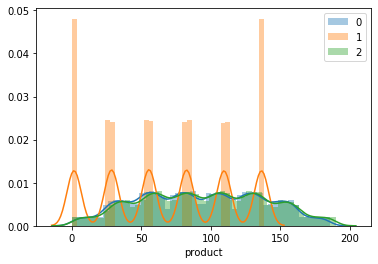

In [8]:
for i, df in enumerate(dfs):
    sns.distplot(df['product'], label=i)
    plt.legend()

Видно что для региона с номером 1, распределнение запасов в месторождениях существенно отличается от 0 и 2. есть ярко выраженные пики, где сконцетрированы месторождения.

Дополнительно посмотрим на зависимости признаков друг от друга для выделяющегося региона

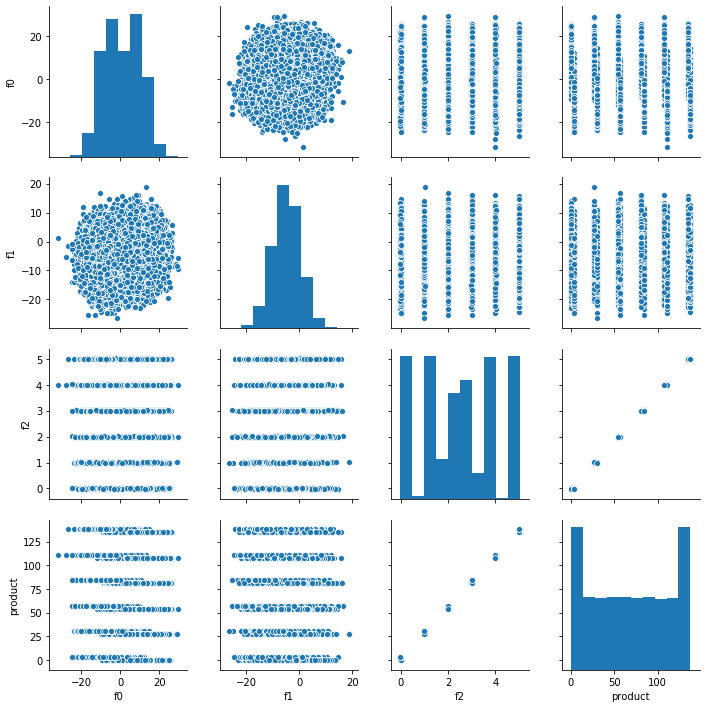

In [9]:
sns.pairplot(dfs[1])

Отметим почти линейную зависимость f2 от product, соотвественно от этого скорее всего и возникает хорошее качество линейной модели

# 3. Подготовка к расчёту прибыли

Посчитаем минимальное количество баррелей которые необходимы для разарботки одного месторождения

In [10]:
min_barrels = ONE_WELL_COST / (BARREL_PROFIT * 1000)
min_barrels

11.11111111111111

Так же определим какое максимальное количество месторождений можно разработать

In [11]:
max_wells = int(TOTAL_BUDGET / ONE_WELL_COST)
max_wells

200

Функция для расчета прибыли

In [12]:
def revenue(target, probabilities, count):
    top = probabilities.sort_values(ascending=False).head(count)
    total_profit = (target.loc[top.index] * 1000 * BARREL_PROFIT).sum()
    return total_profit - (ONE_WELL_COST * count)

# 4. Расчёт прибыли и рисков 

Сделаем бутстреп для каждого региона, посмотрим на прибыль и 95% доверительный интервал.

Построим гистограммы для каждого региона

,mean,95_conf_interval,std,loss_wells_count
0,9.621562e+10,"(90352149484.11848, 102663561502.08168)",3.245282e+09,0
1,9.632379e+10,"(91485496566.3945, 101715176575.40276)",2.624475e+09,0
2,9.600111e+10,"(90013996051.25992, 102464640327.57457)",3.126136e+09,0


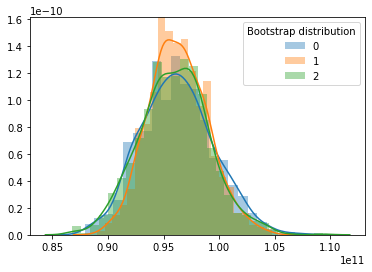

In [13]:
res = defaultdict(list)
random_state = np.random.RandomState(seed=SEED)

for j, (y_valid, y_pred) in enumerate(zip(yy_valid, yy_pred)):
    values = []
    
    for i in range(BOOTSTRAP_SAMPLES):
        target_subsample = y_valid.sample(WELL_POINTS, replace=True, random_state=random_state)
        probs_subsample = y_pred.loc[target_subsample.index]
        values.append(revenue(target_subsample, probs_subsample, max_wells))   
    
    values = pd.Series(values)
    lower = (1 - CONF_INTERVAL) / 2
    upper = (1 + CONF_INTERVAL) / 2
    res['mean'].append(values.mean())
    res['95_conf_interval'].append((values.quantile(lower), values.quantile(upper)))
    res['std'].append(values.std())
    res['loss_wells_count'].append((values < 0).sum())
    sns.distplot(values, label=j)
    plt.legend(title="Bootstrap distribution")

pd.DataFrame(res)

Я бы выбрал регион с номером 1, так как в нем самая высокая средняя прибыть и самый узкий 95% доверительный интервал.